In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline
from scipy.stats import zscore
import imp
# modules
import decoders, utils, tuning, learning, mainfigs, suppfigs

### WHERE YOU DOWNLOADED THE FIGSHARE
dataroot = '/home/carsen/dm11/releases/stringer-et-al-2019a/fs125'

# file list
db = np.load(os.path.join(dataroot, 'database.npy'), allow_pickle=True)
# update database
db = np.insert(db, 27, {'mouse_name': 'TX38', 'date': '2019_10_17', 
               'block': '3', 'expt': 'static_sin_rand'})
db = np.insert(db, 28, {'mouse_name': 'TX34', 'date': '2019_10_21', 
               'block': '1', 'expt': 'static_sin_rand'})
db = np.insert(db, 29, {'mouse_name': 'TX36', 'date': '2019_10_21', 
               'block': '1', 'expt': 'static_sin_rand'})
fs = []
for di in db:
    mname = di['mouse_name']
    datexp = di['date']
    blk = di['block']
    stype = di['expt']
    
    fname = '%s_%s_%s_%s.npy'%(stype, mname, datexp, blk)
    fs.append(os.path.join(dataroot, fname))

### WHERE YOU WANT TO SAVE THE OUTPUTS OF THE ANALYSIS SCRIPTS AND THE FIGURES (if save_figure=True)
saveroot = '/media/carsen/DATA1/2P/ori_data/'

In [ ]:
#~~~~~~~~~~~~~~~ DATA ANALYSIS ~~~~~~~~~~~~~~~~~~~~~~~~~#


################### DECODING ANGLES 0-360 #######################
dstr = ['independent', 'linear']
for dtype in range(2):
    print('>>>>>>>>>> %s <<<<<<<<<<<<<<'%dstr[dtype])
    if dtype==0:
        islinear=False
    else:
        islinear=True
        
    ### DECODER
    nangles = 2 * np.pi * np.ones((len(fs)-5,))
    nangles[-3:] = np.pi
    if dtype==1:
        E, errors, stims, SNR, theta_pref = decoders.run_decoder(fs[:-5], 
                                                             linear=islinear, 
                                                             nangles=nangles)
        np.save(os.path.join(saveroot,'%s_decoder_all_stims.npy'%dstr[dtype]), 
                {'E': E, 'errors': errors, 'stims': stims})
    
    ### ASYMPTOTIC ANALYSIS
    E, ccE, nsplit, npop, nstim, E2 = decoders.asymptotics(fs[:6], linear=islinear)
    np.save(os.path.join(saveroot,'%s_decoder_asymp.npy'%dstr[dtype]), 
                    {'E': E, 'ccE': ccE, 'nsplit': nsplit, 'npop': npop, 'nstim': nstim, 'E2': E2})

### decoding with subtracting spont
E, errors, stims, SNR, theta_pref = decoders.run_decoder(fs[:-5], linear=islinear, npc=32)
np.save(os.path.join(saveroot,'%s_decoder_without_spont.npy'%dstr[dtype]), 
                {'E': E, 'errors': errors, 'stims': stims})

### linear decoding from PC's
nPC = 2**np.arange(2,13,1)
errors, apreds, atrues = decoders.pc_decoding(fs[:6], nPC)
np.save(os.path.join(saveroot, 'pcdecode.npy'), 
        {'errors': errors, 'apreds': apreds, 'atrues': atrues, 'nPC': nPC})

### linear decoding from dense recordings for information content
Eneur, Estim, npop, nstim = decoders.dense_asymptotics(fs[-5:])
np.save(os.path.join(saveroot, 'dense_decoding.npy'), 
        {'npop': npop, 'nstim': nstim, 'Eneur': Eneur, 'Estim': Estim})

In [ ]:
#################### SINGLE NEURON STATS ########################

# load a dataset for stim distances
dat = np.load(fs[0], allow_pickle=True).item()
sresp, istim, itrain, itest = utils.compile_resp(dat, npc=0)

### STIMULUS DISTANCES
cc, dtheta_aligned, cbinned, embedding = tuning.population_distances(sresp, istim)
np.save(os.path.join(saveroot,'popdist.npy'), 
        {'cc':cc, 'dtheta_aligned': dtheta_aligned, 'cbinned':cbinned,'embedding':embedding, 'istim': istim})

###### population tuning curves
d = np.load(os.path.join(saveroot, 'independent_decoder_all_stims.npy'), allow_pickle=True).item()
angle_pref = d['theta_pref']
### static gratings population tuning curves
avg_tuning, tbins = tuning.population_tuning(fs[:6], angle_pref[:6], saveroot)
np.save(os.path.join(saveroot,'avgneur_static.npy'), 
        {'avg_tuning': avg_tuning, 'thetas': angle_pref[:6], 'tbins': tbins})

### drifting gratings population tuning curves
avg_tuning, tbins = tuning.population_tuning(fs[18:21], angle_pref[18:21], saveroot)
np.save(os.path.join(saveroot,'avgneur_drifting.npy'), 
        {'avg_tuning': avg_tuning, 'thetas': angle_pref[18:21], 'tbins': tbins})
    
sigvar, twor_ex = tuning.signal_variance(fs[:6])    
np.save(os.path.join(saveroot, 'twop_sigvar.npy'), {'sigvar': sigvar, 'twor_ex': A})

In [ ]:
################ DISCRIMINATION TASK #######################
print('DISCRIMINATION')

### linear discriminator (all datasets except biased)
nangles = 2 * np.pi * np.ones((len(fs)-5,))
nangles[-3:] = np.pi
P,d75,drange = decoders.run_discrimination(fs[:-5], nangles=nangles, decoder='linear')
np.save(os.path.join(saveroot, 'linear_discrimination.npy'), 
        {'P': P, 'd75': d75, 'drange': drange})

### linear discriminator on biased datasets (43-47 degree stimuli shown only)
npop,nstim,Pall,drange = decoders.dense_discrimination(fs[-5:])
np.save(os.path.join(saveroot, 'dense_discrimination.npy'), 
        {'npop': npop, 'nstim': nstim, 'Pall': Pall, 'drange': drange})

###  discrimination in passive versus running trials
all_running = np.load(os.path.join(dataroot, 'all_running.npy'), allow_pickle=True)
P,d75,drange = decoders.runspeed_discrimination(fs[:6], all_running[:6])
np.save(os.path.join(saveroot, 'runspeed_discrimination.npy'), {'P': P, 'd75': d75, 'drange': drange})

### depth discrimination (split into layers 2/3 and layer 4)
all_depths = np.load(os.path.join(dataroot, 'all_depths.npy'), allow_pickle=True)
P,d75,drange = decoders.layer_discrimination(fs[:6], all_depths[:6])
np.save(os.path.join(saveroot, 'layer_discrimination.npy'), {'P': P, 'd75': d75, 'drange': drange})

### chron discrimination (split train/test in time)
P,d75,drange = decoders.chron_discrimination(fs[:6], all_depths[:6])
np.save(os.path.join(saveroot, 'chron_discrimination.npy'), {'P': P, 'd75': d75, 'drange': drange})

### neural network discriminator
P,d75,drange = decoders.run_discrimination(fs[:6], decoder='deep_net')
np.save(os.path.join(saveroot, 'nn_discrimination.npy'), {'P': P, 'd75': d75, 'drange': drange})

### random forest discriminator
P,d75,drange = decoders.run_discrimination(fs[:6], decoder='random_forest')
np.save(os.path.join(saveroot, 'rf_discrimination.npy'), {'P': P, 'd75': d75, 'drange': drange})

In [ ]:
#~~~~~~~~~~~~~~~ PERCEPTRONS ~~~~~~~~~~~~~~~~~~~~~~~~~#

### PERCEPTRONS
# train on easy task
nstim32, perf32 = learning.train_perceptrons(fs[:6], task_type='easy')
# train on hard task
nstim, perf = learning.train_perceptrons(fs[:-5], task_type='hard')
np.save(os.path.join(saveroot, 'strong_learn.npy'), 
         {'nstim32': nstim32, 'perf32': perf32, 'perf': perf, 'nstim': nstim})


### WEAK LEARNERS
# train on easy task
P, drange, ccN = learning.train_weak_learners(fs[:6])
np.save(os.path.join(saveroot, 'weak_learn.npy'), {'P': P, 'drange': drange, 'ccN': ccN})

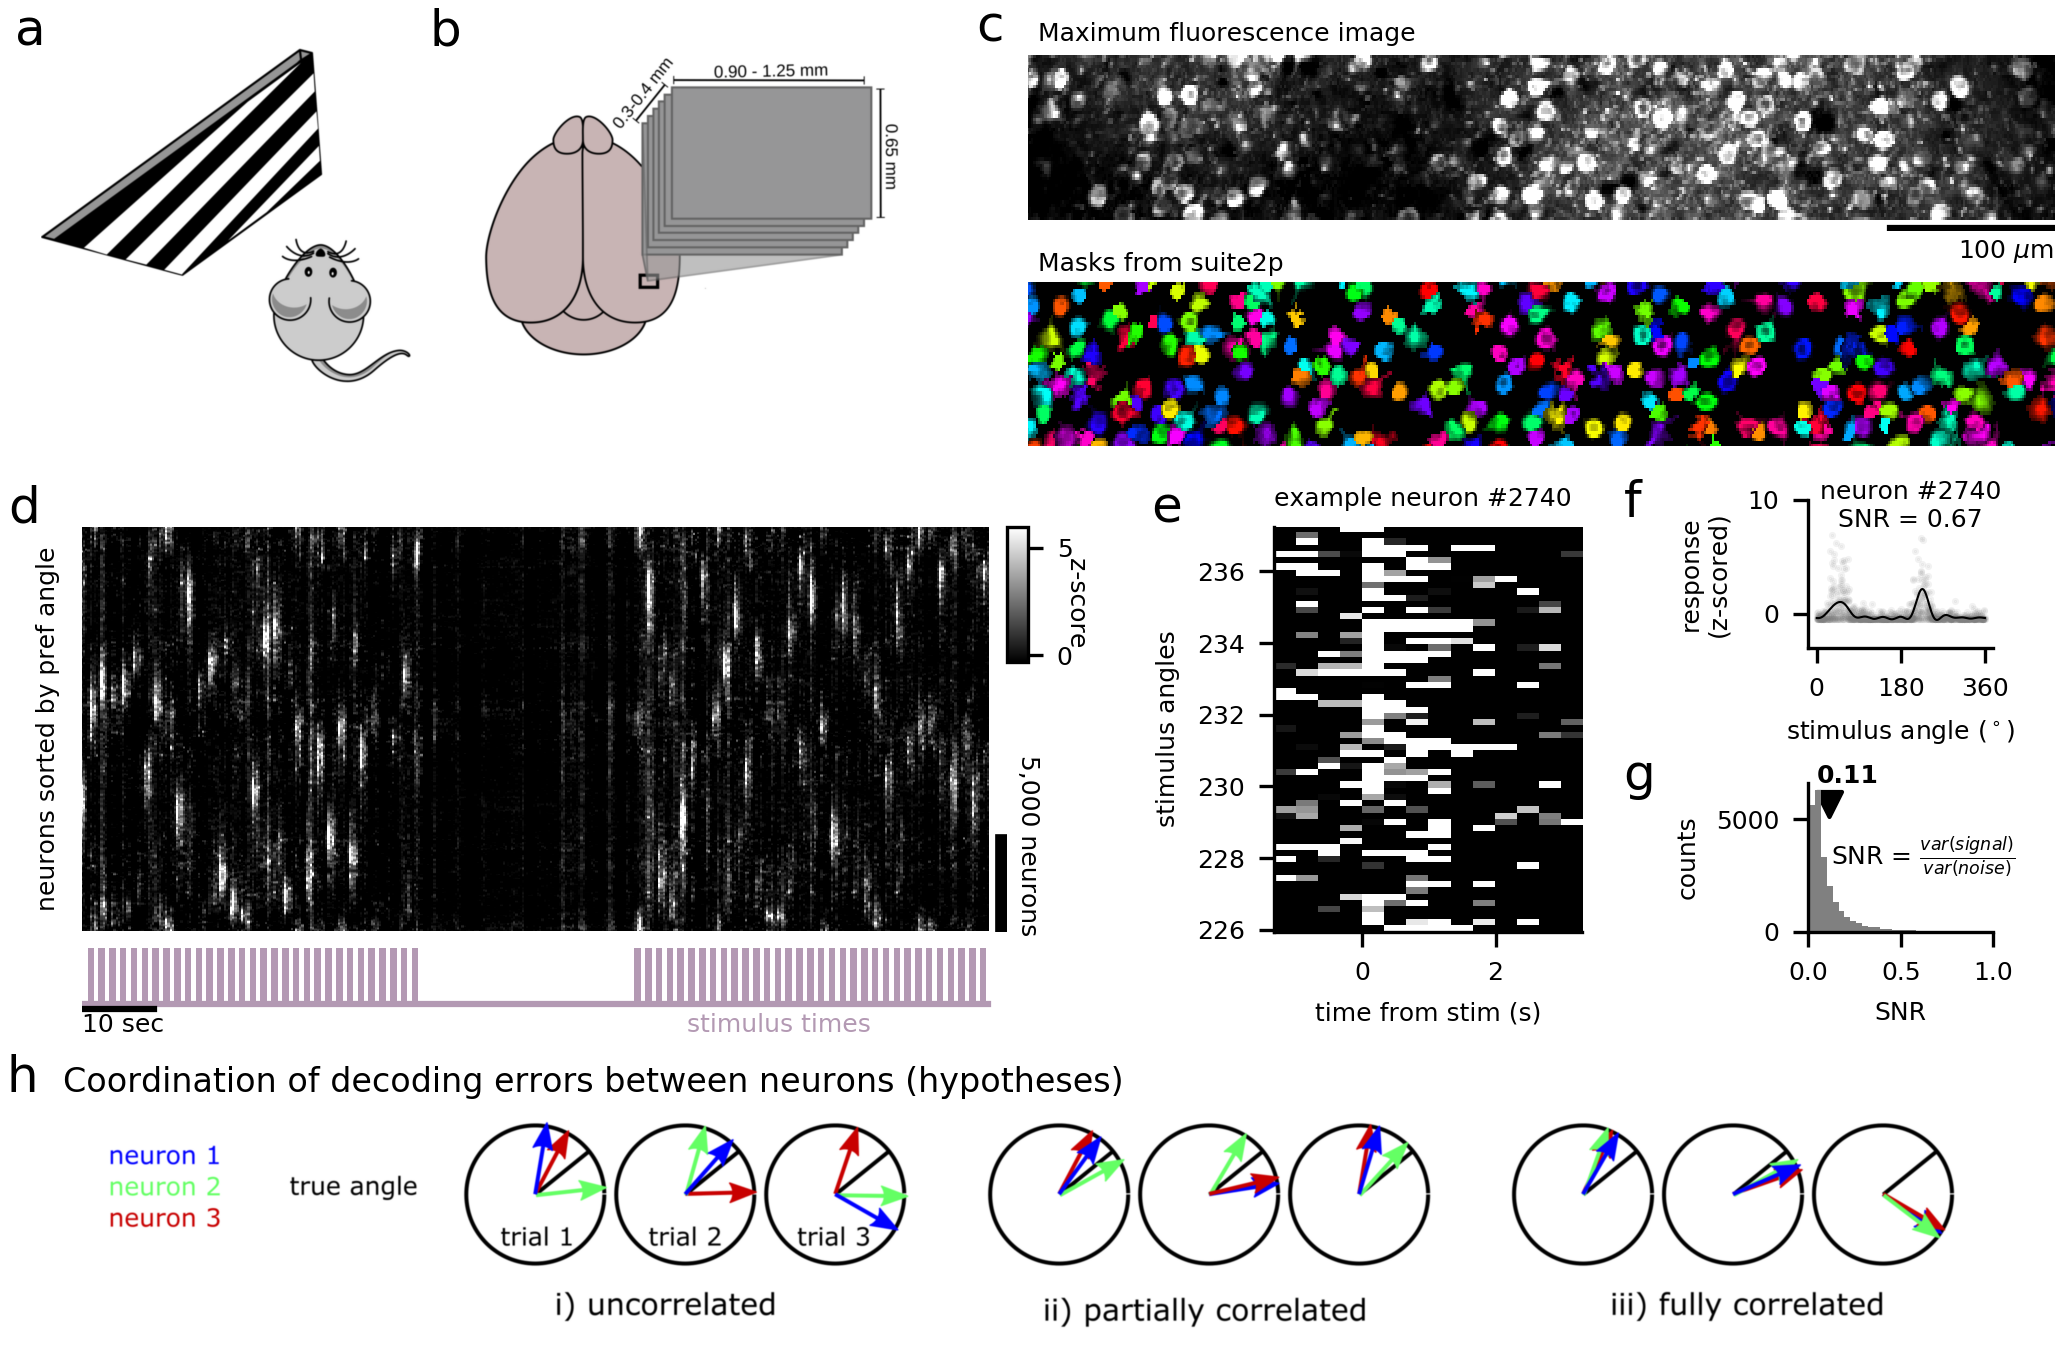

In [5]:
%config InlineBackend.close_figures = False
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

imp.reload(mainfigs)
imp.reload(suppfigs)

#### MAIN FIGURES

f = mainfigs.fig1(dataroot, saveroot, True)

f = mainfigs.fig2(dataroot, saveroot, True)

f = mainfigs.fig3(dataroot,saveroot, True)

f = mainfigs.fig4(dataroot, saveroot, True)

f = mainfigs.fig5(dataroot, saveroot, True)

f = mainfigs.fig6(dataroot, saveroot, True)

#### SUPPLEMENTARY FIGURES
# if you want to save the figures, add an optional input save_figure=True


f = suppfigs.stim_props(saveroot, True)

f = suppfigs.pc_errors(saveroot, True)

f = suppfigs.linear_decoders(dataroot, saveroot, True)

f = suppfigs.spont_sub(saveroot, True)

f = suppfigs.discr_all(saveroot, True)
